# Building Markov Features 

In this notebook I am going to illustrate how to create Markov features from scratch. To run this notebook, some helpers will be used. 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pylab as plt

In [2]:
from helpers_ngrams import encode_states
from BigramModel import *
from datasets import make_sequential

In [3]:
df1_raw = make_sequential(n_samples=10000, n_sequences=1000, random_state=11)

In [4]:
df2_raw = make_sequential(n_samples=10000, n_sequences=1000, random_state=2)

In [5]:
def diff(df):
    for v in ["v1", "v2", "v3"]:
        df[v] = np.sign(df[v].diff())
    return df

In [6]:
def massage(df):
    variables = ["v1", "v2", "v3"]
    df = df.groupby("sequence").apply(diff)
    df = df.dropna()
    df[variables] = df[variables].astype(np.int) + 1
    df["state"] = encode_states(df[["v1", "v2", "v3"]])
    
    return df

In [7]:
df1 = massage(df1_raw)
df2 = massage(df2_raw)

Let us have a look at the data:

In [8]:
print("First data-frame: ", '\n', df1_raw.head(), '\n', 
      "Second data-frame: ", '\n', df2_raw.head())

First data-frame:  
    sequence        v1        v2        v3
0         0 -0.136187  0.065560 -0.054400
1         0 -0.203301  0.065560 -0.110613
2         0 -0.222885  0.065560 -0.150528
3         0 -0.222885  0.101262 -0.150528
4         0 -0.245426  0.116405 -0.150528 
 Second data-frame:  
    sequence        v1        v2        v3
0         0 -0.009659 -0.113660 -0.068069
1         0  0.095460  0.032746 -0.222778
2         0  0.032292 -0.047002 -0.248339
3         0  0.014389 -0.126145 -0.237008
4         0  0.039622 -0.139837 -0.252373


In [9]:
print("First data-frame - encoded: ", '\n', df1.head(10), '\n', 
      "Second data-frame - encoded: ", '\n', df2.head(10))

First data-frame - encoded:  
     sequence  v1  v2  v3  state
1          0   0   1   0      3
2          0   0   1   0      3
3          0   1   2   1     16
4          0   0   2   1     15
5          0   1   2   2     25
6          0   0   0   0      0
8          1   0   2   0      6
9          1   0   1   0      3
10         1   2   2   2     26
11         1   0   0   0      0 
 Second data-frame - encoded:  
     sequence  v1  v2  v3  state
1          0   2   2   0      8
2          0   0   0   0      0
3          0   0   0   2     18
4          0   2   0   0      2
5          0   0   0   2     18
6          0   2   2   0      8
7          0   0   0   2     18
8          0   2   2   0      8
9          0   0   0   2     18
10         0   2   2   0      8


At this point we are ready to calculate the Markov features. For this I will use the class ```BigramModel```.

In [10]:
model_1 = BigramModel()

In [11]:
model_1.fit(df1["state"], df1["sequence"])

In [13]:
model_2 = BigramModel()

In [14]:
model_2.fit(df2["state"], df2["sequence"])

#### Display results
The ```fit``` will perform all the calculations and provide with all the calculations.

Let us have a look how frequent were the states in the data - sets.

In [15]:
print("First data-set: ", '\n',model_1.single_counts_df.sort_values(by='state').head(),
      '\n', "Second data-set: ", '\n', model_2.single_counts_df.sort_values(by='state').head())

First data-set:  
    state  frequency
0      0       2292
1      1        388
2      2        746
3      3        405
4      4         54 
 Second data-set:  
    state  frequency
0      0        277
1      1        298
2      2        449
3      3         58
4      4         98


Let us have a look on which are the most frequent sequences: 

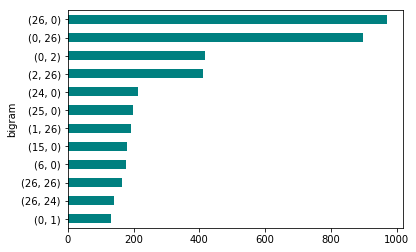

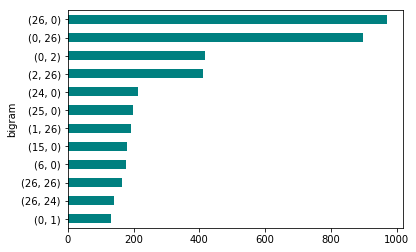

In [16]:
model_1.plot_frequency(n_most_frequent=12)
model_1.plot_frequency(n_most_frequent=12)

In [17]:
model_2.predict_grouped_probas(df2["state"].values, df2["sequence"])

### Probability Matrix
Are you curious about the probability matrix? 
Let's have a look.

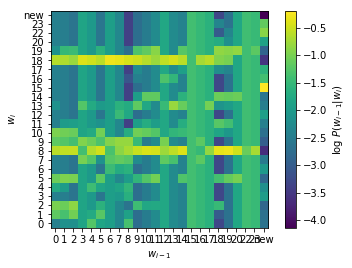

In [18]:
model_2.plot_proba_matrix(log=True)

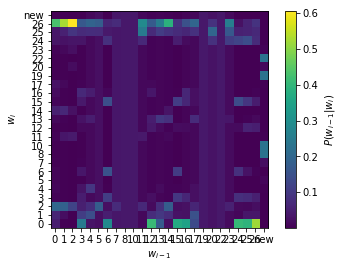

In [19]:
model_1.plot_proba_matrix(log=False)

We are ready to create Markov features.

In [20]:
model_1.predict_proba_stats(df2["state"], df2["sequence"]).head()

,person_id,V_Markov_seq_prob_log_mean,V_Markov_seq_prob_log_median,V_Markov_seq_prob_log_tot,V_Markov_seq_prob_max,V_Markov_seq_prob_mean,V_Markov_seq_prob_median,V_Markov_seq_prob_min
0,0,-1.078504,-1.397940,-39.365208,0.231064,0.083463,0.040000,0.000101
1,1,-1.202606,-1.397940,-13.707578,0.231064,0.062718,0.040000,0.000026
2,2,-1.088941,-1.088941,-2.308166,0.122963,0.081481,0.081481,0.040000
3,4,-1.546433,-1.397940,-7.843544,0.040000,0.028416,0.040000,0.005952
4,5,-1.744492,-1.591065,-5.743231,0.025641,0.018010,0.025641,0.002747


If you would like to create more features, add them in the class and it will return them.

#### Are these features predective? 

In [21]:
probs2 = model_1.predict_proba_stats(df2["state"], df2["sequence"])["V_Markov_seq_prob_median"].values
probs1 = model_1.predict_proba_stats(df1["state"], df1["sequence"])["V_Markov_seq_prob_median"].values

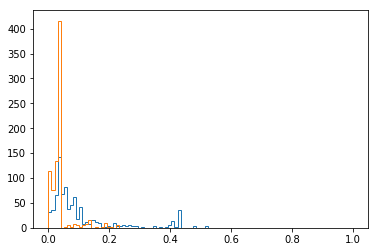

In [22]:
bins = np.linspace(0,1,100)
plt.hist(probs1, bins=bins, histtype="step")
plt.hist(probs2, bins=bins, histtype="step")
plt.show()

## Imputing missing values
Few words about missing values: 

- missing values are present when in the data set are sequences with one state only
- imputing missing values is preferred be done outside the class
- example function below

In [23]:
def replace_Markov_missing_values(df, log_values = 0, nolog_values = 1):
    '''
    Retrieves all the Markov features, and replaces them by 1 or 0 if we have log or not
    Args:
        df (dataframe) : pandas dataframe with Markov features
        log_values (int): value to fill the missing values
        nolog_values (int): value to fill the missing values
    Returns:
        df (pandas dataframe): in this dataframe the missing values of the column col have been replaced
    '''
    for col in df.columns:
        if col.startswith('V_Markov_log'):
            df[col] = df[col].fillna(value = log_values)
        if col.startswith('V_Markov_seq'):
            df[col] = df[col].fillna(value = nolog_values)

    return df

#### Some notes in the ```class BigramModel``

In [ ]:
predict_mean_proba